In [35]:
import os
import json
import shutil
from PIL import Image, ImageDraw
import numpy as np
import torch
import torchvision
from torchvision.datasets import CocoDetection
from torchvision.transforms import v2 as T_v2
from torchvision import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import timm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from transformers import Trainer, TrainingArguments
from torchmetrics.detection import MeanAveragePrecision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [36]:
# --- Конфигурация ---
DATA_DIR = "../data/Bamberg_coco2048/coco2048"
IMG_DIR_TRAIN = os.path.join(DATA_DIR, "train2023")
IMG_DIR_VAL = os.path.join(DATA_DIR, "test2023")
ANN_FILE_TRAIN = os.path.join(DATA_DIR, "annotations/instances_tree_train2023.json")
ANN_FILE_VAL = os.path.join(DATA_DIR, "annotations/instances_tree_eval2023.json")

IMG_WIDTH = 2048
IMG_HEIGHT = 2048
NUM_CLASSES = 1  # 1 (дерево)
TREE_CATEGORY_ID = 1
NUM_TRAIN_IMAGES = 20 # Количество тренировочных изображений
NUM_VAL_IMAGES = 10   # Количество валидационных изображений

### 1.2. Загрузка данных с `torchvision.datasets.CocoDetection`

In [ ]:
# Используем `CocoDetection` и оборачиваем его с помощью `wrap_dataset_for_transforms_v2` для совместимости с `torchvision.transforms.v2` и Albumentations. (Раздел 1.2, 2.1 из отчета)

# Загрузчик CocoDetection
raw_train_dataset = CocoDetection(root=IMG_DIR_TRAIN, annFile=ANN_FILE_TRAIN)
raw_val_dataset = CocoDetection(root=IMG_DIR_TRAIN, annFile=ANN_FILE_VAL)

# Обертка для transforms_v2
# target_keys должны соответствовать тому, что возвращает CocoDetection и что нужно для аугментаций/модели
# CocoDetection возвращает 'boxes', 'labels', 'masks' (если есть)
# Важно: CocoDetection по умолчанию может не генерировать 'masks' из полигонов.
# Для реальных данных COCO это работает. Для наших dummy data, segmentation - это полигоны.
# wrap_dataset_for_transforms_v2 ожидает, что 'masks' будут доступны.
# torchvision.datasets.CocoDetection преобразует полигоны в маски.

# Указываем, что хотим получить 'masks' и 'boxes' из аннотаций
# CocoDetection сам преобразует полигоны в маски

train_dataset_wrapped = datasets.wrap_dataset_for_transforms_v2(raw_train_dataset, target_keys=["boxes", "labels", "masks"])
val_dataset_wrapped = datasets.wrap_dataset_for_transforms_v2(raw_val_dataset, target_keys=["boxes", "labels", "masks"])

sample_img, sample_target = train_dataset_wrapped[0]

print(f"Тип данных после wrap_dataset_for_transforms_v2 (пример): {type(sample_target)}")
print(f"Содержимое target после wrap_dataset_for_transforms_v2 (пример):")
for k, v in sample_target.items():
    print(f"  {k}: type={type(v)}, shape/value={v.shape if hasattr(v, 'shape') else v}")

assert isinstance(sample_target['boxes'], torchvision.tv_tensors.BoundingBoxes)
assert isinstance(sample_target['masks'], torchvision.tv_tensors.Mask)
assert sample_target['labels'].ndim == 1 # Должен быть 1D тензор меток


loading annotations into memory...
Done (t=1.43s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Тип данных после wrap_dataset_for_transforms_v2 (пример): <class 'dict'>
Содержимое target после wrap_dataset_for_transforms_v2 (пример):
  boxes: type=<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>, shape/value=torch.Size([48, 4])
  masks: type=<class 'torchvision.tv_tensors._mask.Mask'>, shape/value=torch.Size([48, 2048, 2048])
  labels: type=<class 'torch.Tensor'>, shape/value=torch.Size([48])


### 1.3. Аугментация с Albumentations

In [38]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5, border_mode=0), # cv2.BORDER_CONSTANT
            A.RandomResizedCrop(size=(IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.HueSaturationValue(p=0.2),
            A.GaussNoise(p=0.2),
            # A.CoarseDropout(max_holes=8, max_height=int(IMG_HEIGHT*0.1), max_width=int(IMG_WIDTH*0.1),
            #                 min_holes=1, min_height=int(IMG_HEIGHT*0.05), min_width=int(IMG_WIDTH*0.05),
            #                 fill_value=0, mask_fill_value=0, p=0.2), # mask_fill_value для масок
            # Нормализация и ToTensorV2 будут последними
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(), # Важно: преобразует в тензор и меняет HWC на CHW
        ],
        bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'], min_visibility=0.1)
        # 'mask_params' не нужен явно, если маски передаются как 'masks' и имеют правильный формат (N, H, W)
    )

def get_val_transforms():
    return A.Compose(
        [
            A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH), # Валидационный набор обычно только изменяет размер и нормализует
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])
    )

### 1.4. Класс-обертка для применения трансформаций Albumentations

In [ ]:
# Этот класс будет принимать изображение и таргеты от `wrap_dataset_for_transforms_v2` и применять аугментации.

class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __getitem__(self, idx):
        # Получаем данные из обернутого датасета
        img, target = self.dataset[idx] # img - PIL Image, target - dict of tv_tensors

        # Конвертируем в NumPy для Albumentations
        img_np = np.array(img)

        # Bounding boxes: torchvision format [xmin, ymin, xmax, ymax]
        # Albumentations 'coco' format: [xmin, ymin, width, height]
        boxes_tv = target['boxes']
        if boxes_tv.ndim == 1 and boxes_tv.numel() == 0: # Нет объектов
             boxes_coco = np.empty((0,4), dtype=np.float32)
             labels_np = np.empty((0,), dtype=np.int64)
             masks_np = np.empty((0, img_np.shape[0], img_np.shape[1]), dtype=np.uint8)
        else:
            # Конвертация BoundingBoxes из [xmin, ymin, xmax, ymax] в [xmin, ymin, width, height]
            boxes_coco = torchvision.ops.box_convert(boxes_tv, in_fmt='xyxy', out_fmt='xywh').numpy()
            labels_np = target['labels'].nuМаски из {max_masks} классовmpy()
            # Маски: torchvision (N, H, W), Albumentations ожидает список масок (H, W) или (N, H, W)
            masks_np = target['masks'].numpy().astype(np.uint8) # (N, H, W)
            if masks_np.ndim == 2: # если только одна маска, добавляем batch dim
                masks_np = masks_np[np.newaxis, ...]


        # Применяем трансформации
        # Albumentations работает с именованными аргументами image, masks, bboxes, class_labels
        transformed = self.transforms(image=img_np, masks=list(masks_np), bboxes=boxes_coco, class_labels=labels_np)
        # `list(masks_np)` если каждая маска (H,W). Если (N,H,W), то просто `masks=masks_np`

        img_transformed = transformed['image'] # Уже тензор (C, H, W) благодаря ToTensorV2
        masks_transformed_list = transformed['masks'] # список NumPy масок (H, W)
        bboxes_transformed_coco = np.array(transformed['bboxes'], dtype=np.float32)
        labels_transformed = torch.tensor(transformed['class_labels'], dtype=torch.int64)

        # Формируем новый target
        new_target = {}

        if len(bboxes_transformed_coco) > 0:
            # Обратная конвертация bbox в [xmin, ymin, xmax, ymax] для модели
            bboxes_transformed_xyxy = torchvision.ops.box_convert(
                torch.from_numpy(bboxes_transformed_coco), in_fmt='xywh', out_fmt='xyxy'
            )
            new_target['boxes'] = bboxes_transformed_xyxy
            new_target['labels'] = labels_transformed

            # Собираем маски обратно в тензор (N, H, W)
            if masks_transformed_list:
                # Убедимся, что маски имеют правильный тип и форму
                masks_tensor = torch.stack([m.to(torch.uint8) for m in masks_transformed_list])
                new_target['masks'] = masks_tensor
            else: # если после аугментации не осталось масок, но есть боксы (маловероятно, но возможно)
                new_target['masks'] = torch.empty((0, img_transformed.shape[1], img_transformed.shape[2]), dtype=torch.uint8)

        else: # Если нет объектов после аугментации
            new_target['boxes'] = torch.empty((0, 4), dtype=torch.float32)
            new_target['labels'] = torch.empty((0,), dtype=torch.int64)
            new_target['masks'] = torch.empty((0, img_transformed.shape[1], img_transformed.shape[2]), dtype=torch.uint8)

        # Важно: модели torchvision detection ожидают labels как Int64Tensor
        new_target['image_id'] = torch.tensor([idx]) # Для некоторых метрик может понадобиться

        return img_transformed, new_target

    def __len__(self):
        return len(self.dataset)

In [41]:
train_dataset = AlbumentationsDataset(train_dataset_wrapped, get_train_transforms())
val_dataset = AlbumentationsDataset(val_dataset_wrapped, get_val_transforms())

/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [42]:
img_transformed, target_transformed = train_dataset[0]
print("\n--- Пример аугментированных данных ---")
print(f"Image shape: {img_transformed.shape}, type: {img_transformed.dtype}")
print(f"Target keys: {target_transformed.keys()}")
print(f"Boxes shape: {target_transformed['boxes'].shape}, type: {target_transformed['boxes'].dtype}")
print(f"Labels: {target_transformed['labels']}, type: {target_transformed['labels'].dtype}")
print(f"Masks shape: {target_transformed['masks'].shape}, type: {target_transformed['masks'].dtype}")


--- Пример аугментированных данных ---
Image shape: torch.Size([3, 2048, 2048]), type: torch.float32
Target keys: dict_keys(['boxes', 'labels', 'masks', 'image_id'])
Boxes shape: torch.Size([43, 4]), type: torch.float32
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), type: torch.int64
Masks shape: torch.Size([48, 2048, 2048]), type: torch.uint8


Размер изображения: (2048, 2048, 3)


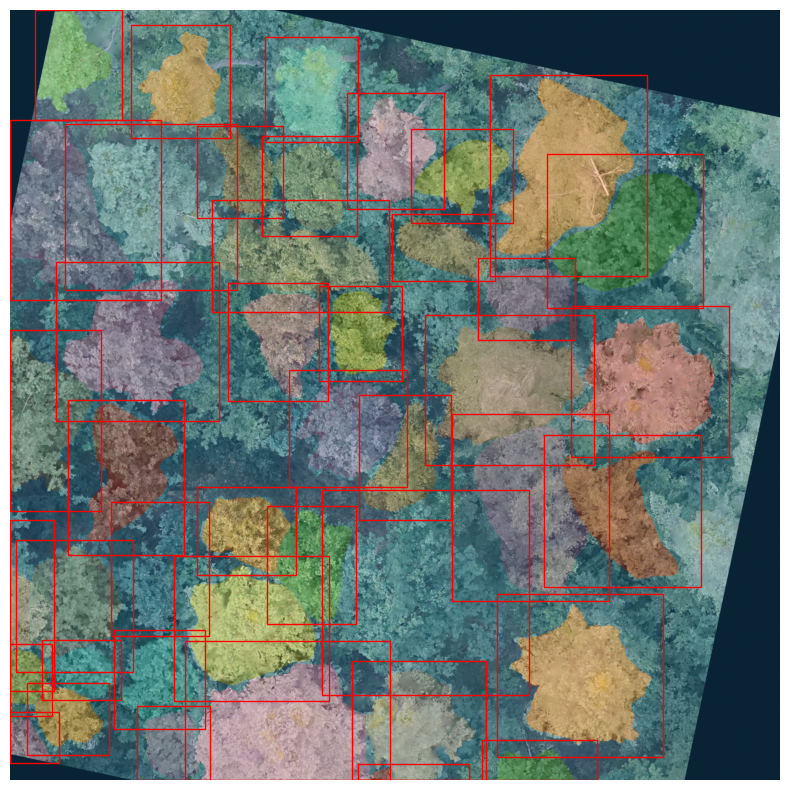

In [48]:
def show_sample(image_tensor, target, max_masks=50):
    # Определяем параметры нормализации
    fig, ax = plt.subplots(1, figsize=(8,8))
    # Денормализация и изменение порядка осей для отображения
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = image_tensor.permute(1, 2, 0).cpu().numpy() # C,H,W -> H,W,C
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)
    ax.imshow(img_display)
    print(f"Размер изображения: {img_display.shape}")

    
    
    # Остальной код без изменений
    if 'masks' in target and target['masks'].numel() > 0:
        masks = target['masks'].cpu().float()
        combined_mask = torch.zeros(masks.shape[1:], dtype=torch.int32)
        
        for i in range(min(masks.shape[0], max_masks)):
            combined_mask = torch.where(masks[i] > 0.5, i+1, combined_mask)
        
        cmap = plt.get_cmap('tab10')
        colored_mask = cmap(combined_mask.numpy() % 10)[..., :3]
        ax.imshow(colored_mask, alpha=0.3)

    if 'boxes' in target and target['boxes'].numel() > 0:
        boxes = target['boxes'].cpu().numpy()
        for box in boxes:
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                fill=False, edgecolor='red', linewidth=1
            ))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample(img_transformed, target_transformed)


### 1.5. Пользовательская функция коллации (Custom Collate Function)

In [ ]:
# `DataLoader` требует `collate_fn` для обработки пакетов с переменным числом объектов.
# Функция будет возвращать кортеж из списка изображений и списка словарей targets.

def collate_fn(batch):
    # batch - это список кортежей (image, target)
    # Нужно транспонировать в (list_of_images, list_of_targets)
    return tuple(zip(*batch))

# Создаем DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=1)

# Проверка одного батча
images_batch, targets_batch = next(iter(train_dataloader))
print(f"\n--- Проверка DataLoader ---")
print(f"Количество изображений в батче: {len(images_batch)}")
print(f"Тип первого изображения: {type(images_batch[0])}, форма: {images_batch[0].shape}")
print(f"Количество таргетов в батче: {len(targets_batch)}")
print(f"Тип первого таргета: {type(targets_batch[0])}")
print(f"Ключи в первом таргете: {targets_batch[0].keys()}")


--- Проверка DataLoader ---
Количество изображений в батче: 2
Тип первого изображения: <class 'torch.Tensor'>, форма: torch.Size([3, 2048, 2048])
Количество таргетов в батче: 2
Тип первого таргета: <class 'dict'>
Ключи в первом таргете: dict_keys(['boxes', 'labels', 'masks', 'image_id'])


In [47]:
training_args = TrainingArguments(
    output_dir='./results_maskrcnn_convnextv2',
    num_train_epochs=3, # Уменьшим для демонстрации
    per_device_train_batch_size=2, # Должно соответствовать DataLoader, если используется Trainer напрямую с Dataset
    per_device_eval_batch_size=2,
    warmup_steps=10, # Уменьшим
    weight_decay=0.01,
    logging_dir='./logs_maskrcnn_convnextv2',
    logging_steps=5, # Уменьшим
    eval_strategy="epoch", # Оценивать после каждой эпохи
    save_strategy="epoch",       # Сохранять после каждой эпохи
    load_best_model_at_end=True,
    metric_for_best_model="map", # Используем mAP для выбора лучшей модели
    # report_to="tensorboard", # или wandb, none
    remove_unused_columns=False, # Важно, т.к. наши таргеты - словари и не являются колонками датасета HF
    dataloader_num_workers=2,    # Соответствует DataLoader
    # fp16=torch.cuda.is_available(), # Включить смешанную точность, если есть GPU и поддержка
)

label2id = {"background": 0, "tree": 1}
id2label = {v: k for k, v in label2id.items()}

In [50]:
from transformers import (
    AutoImageProcessor,
    AutoModelForUniversalSegmentation,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
)

model = AutoModelForUniversalSegmentation.from_pretrained(
        'facebook/mask2former-swin-tiny-coco-instance',
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,

    )

image_processor = AutoImageProcessor.from_pretrained(
        'facebook/mask2former-swin-tiny-coco-instance',
        do_resize=True,
        size={"height": 2048, "width": 2048},
    )

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([81]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([81]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=F

In [51]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=image_processor,
    data_collator=collate_fn,
)

In [54]:
# Training
train_result = trainer.train(resume_from_checkpoint=False)
trainer.save_model()
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 43, in do_one_step
    data = pin_memory(data, device)
  File "/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 90, in pin_memory
    pin_memory(sample, device) for sample in data
    ~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 90, in pin_memory
    pin_memory(sample, device) for sample in data
    ~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 77, in pin_memory
    {k: pin_memory(sample, device) for k, sample in data.items()}
        ~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 66, in pin_memory
    return data.pin_memory(device)
           ~~~~~~~~~~~~~~~^^^^^^^^
RuntimeError: CUDA error: invalid argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [55]:
import torch
print(torch.__version__)          # Версия PyTorch
print(torch.version.cuda)         # Версия CUDA в PyTorch
print(torch.cuda.is_available())  # Доступность CUDA


2.7.0+cu126
12.6
True
